In [482]:
#Set your project path & file name 
import pandas as pd 
import numpy as np 
import re 
import sys

In [483]:
data = pd.read_csv("ITSMGROUPR.csv")
data.head()

,Sentences,CI_Cat,CI_Subcat,WBS,Priority,Category,Closure_Code,Assigned_Groups
0,1,subapplication,Web Based Application,WBS000162,4,incident,Other,Dev grp - Software
1,1,application,Web Based Application,WBS000088,3,incident,Software,Dev grp - Software
2,1,application,Desktop Application,WBS000092,3,request for information,No error - works as designed,Dev grp - Software
3,1,application,Web Based Application,WBS000088,4,incident,Operator error,Dev grp - Software
4,1,application,Web Based Application,WBS000088,4,incident,Other,Dev grp - Software


In [485]:
callers = data['CI_Subcat'].unique() 
callers.shape
#itTicketDF.drop(["Caller",'Short description'],axis=1,inplace= True)
#itTicketDF.info()

(66,)

In [486]:
data.shape

(46495, 8)

In [487]:
data['Closure_Code'].unique() 


array(['Other', 'Software', 'No error - works as designed',
       'Operator error', 'Unknown', 'Data', 'Referred',
       'Infra grp - hardware', 'Questions', 'User error', 'Inquiry',
       'User manual not used', 'Kwaliteit van de output', 'other',
       'Overig'], dtype=object)

In [488]:
targetClassCnt=data['Closure_Code'].value_counts()
targetClassCnt.describe()

count       15.000000
mean      3099.666667
std       4926.892264
min          1.000000
25%        160.000000
50%       1537.000000
75%       3254.500000
max      16439.000000
Name: Closure_Code, dtype: float64

In [489]:
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.7.0


In [490]:
print('Unique words in corpus: ', data['CI_Subcat'].nunique())
print('Unique tags in corpus: ', data['Closure_Code'].nunique())

Unique words in corpus:  66
Unique tags in corpus:  15


In [491]:
words = list(set(data['CI_Subcat'].values))
words.append('ENDPAD')
num_words = len(words)
print(num_words)

67


In [492]:
tags = list(set(data['Closure_Code'].values))
num_tags = len(tags)
print(num_tags)

15


In [493]:
num_words, num_tags

(67, 15)

## Retrieve sentences and corresponding tags

In [494]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s['CI_Subcat'].values.tolist(),
                                                         s['CI_Cat'].values.tolist(),
                                                          s['Closure_Code'].values.tolist())]
        self.grouped = self.df.groupby('Sentences').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [495]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [496]:
sentences[3]

[('Printer', 'officeelectronics', 'Other'),
 ('Scanner', 'officeelectronics', 'Infra grp - hardware'),
 ('Printer', 'officeelectronics', 'Software'),
 ('Printer', 'officeelectronics', 'Software'),
 ('Scanner', 'officeelectronics', 'No error - works as designed'),
 ('Printer', 'officeelectronics', 'Software'),
 ('Printer', 'officeelectronics', 'Software'),
 ('Printer', 'officeelectronics', 'Software'),
 ('Scanner', 'officeelectronics', 'Infra grp - hardware'),
 ('Scanner', 'officeelectronics', 'Infra grp - hardware'),
 ('Printer', 'officeelectronics', 'Infra grp - hardware'),
 ('Printer', 'officeelectronics', 'Software'),
 ('Printer', 'officeelectronics', 'User error'),
 ('Printer', 'officeelectronics', 'Software'),
 ('Printer', 'officeelectronics', 'Other'),
 ('Scanner', 'officeelectronics', 'Infra grp - hardware'),
 ('Scanner', 'officeelectronics', 'Other'),
 ('Printer', 'officeelectronics', 'Software'),
 ('Printer', 'officeelectronics', 'Other'),
 ('Scanner', 'officeelectronics', 'Ot

## Define mappings between sentences and tags

In [497]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [149]:
### Padding input sentences and creating train/test split

In [498]:
from matplotlib import pyplot as plt

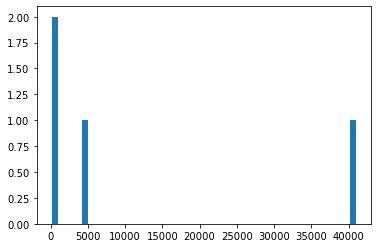

In [501]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show();


In [502]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len =50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['Software'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [503]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Build and compile a Bidirectional LSTM model

In [504]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [505]:
def print_plot(index):
    example = data[data.index == index][['CI_Cat', 'CI_Subcat']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Closure_Code', example[0])
print_plot(10)

application
Closure_Code application


In [506]:
print_plot(100)

application
Closure_Code application


In [507]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_26 (Embedding)    (None, 50, 50)            3350      
                                                                 
 spatial_dropout1d_26 (Spati  (None, 50, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_26 (Bidirecti  (None, 50, 200)          120800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 50, 15)           3015      
 stributed)                                                      
                                                          

In [508]:
#model.compile(optimizer='adam',metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

 ### Train the model

In [344]:
pip install livelossplot

In [509]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [30]:
#lm.fit(train_data, train_labels, epochs=2, validation_data=(val_data, val_labels), shuffle=True)

In [510]:
 X.shape

(4, 50)

In [511]:
Y.shape

(46495, 15)

In [520]:
Y = pd.get_dummies(data['Closure_Code']).values
print('Closure_Code', Y.shape)

Closure_Code (46495, 15)


In [521]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
#    callbacks = callbacks
)

Epoch 1/3
1/1 [==============================] - 0s 76ms/step - loss: 2.6247 - accuracy: 0.2900 - val_loss: 2.6328 - val_accuracy: 0.5200
Epoch 2/3
1/1 [==============================] - 0s 57ms/step - loss: 2.6222 - accuracy: 0.3100 - val_loss: 2.6295 - val_accuracy: 0.5200
Epoch 3/3
1/1 [==============================] - 0s 58ms/step - loss: 2.6172 - accuracy: 0.3000 - val_loss: 2.6261 - val_accuracy: 0.5200


### Evaluate Named Entity Recognition model

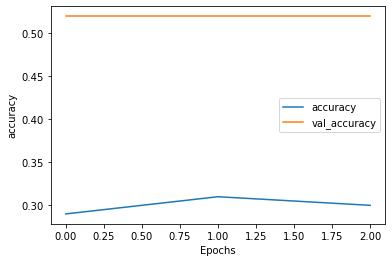

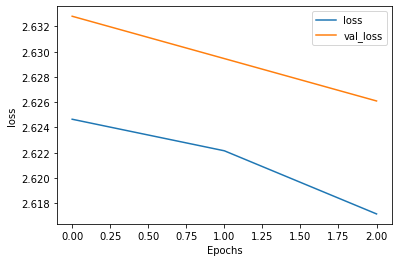

In [522]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [523]:
model.evaluate(x_test, np.array(y_test))

1/1 [==============================] - 0s 19ms/step - loss: 2.6291 - accuracy: 0.2600


[2.6291463375091553, 0.25999999046325684]

In [524]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:25}{:25}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*70)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:25}{:25}\t{:10}'.format(words[w-1], tags[true], tags[pred]))

Word                     True                     	 Pred

----------------------------------------------------------------------
Printer                  Operator error           	Software  
Printer                  Software                 	Software  
Printer                  Other                    	Software  
Printer                  Infra grp - hardware     	Software  
Scanner                  Infra grp - hardware     	Other     
Printer                  Software                 	Other     
Scanner                  Unknown                  	Other     
Scanner                  Other                    	Other     
Printer                  User error               	Other     
Scanner                  Software                 	Other     
Scanner                  Infra grp - hardware     	Other     
Scanner                  Software                 	Other     
Printer                  Software                 	Software  
Scanner                  Other                    	Other     
Pri